In [1]:
y_feature = 'SiteEUIWN(kBtu/sf)'

## 0. Preliminary
    0.1 Import
    0.2 Read CSV
    0.3 Functions
        0.3.1 nan_volumetry
        0.3.2 print_feature_importances_shap_values
        0.3.3 regressor_grid
        0.3.4 regressor_result_DataFrame
        0.3.5 regressor
        0.3.6 regression_with_EnergyStarScore
        0.3.7 plot_r2_score
        0.3.8 r2_mean_barplot

## 1. Preparation DataFrame
    1.1 Standard scaler
    1.2 Train test k-fold split

## 2. Regressor
    2.1 DummyRegressor
    2.2 Linear Regression
    2.3 Elastic Net
    2.4 SVR
    2.5 RandomForestRegressor
    2.6 GradientBostingRegressor
    2.7 XGBoost
    2.8 LGBMRegressor
    2.9 regression_results_data.sort_values('R2_mean')

## 3. EnergyStarScore
    3.1 Best estimator and best param grid
    3.2 EneryStarScore not NaN
    3.3 EnergyStarScore median
    3.4 Overfitting

## 0. Preliminary

### 0.1 Import

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import shap
shap.initjs()

### 0.2 Read CSV

In [3]:
df = pd.read_csv('df_clean.csv')

pd.set_option('display.max_columns', None)

### 0.3 Functions

In [4]:
def nan_volumetry(df, title='NaN Volumetry'):
    """
    Plot a barh graph of NaN percentage values of every columns
    
    """
    plt.rcParams["figure.figsize"] =(10,len(df.columns)/3)
    per_1 = (df.isna().mean().round(4) * 100).sort_values()
    f, ax = plt.subplots()
    for i,item in enumerate(zip(per_1.keys(),per_1.values)):
        ax.barh(item[0], item[1], label = item[0])
        ax.text(1.5,i-0.2, str(item[1])+'%')
    plt.title(title, fontsize=20)
    plt.margins(0)
    plt.xlabel('Percentage')
    plt.ylabel('Columns')
    plt.grid(axis='x')
    plt.show()

In [5]:
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    shap_df = pd.DataFrame(columns= ['Feature', 'Feature_Importance'])
    for k, v in feature_importances.items():
        shap_df = shap_df.append({'Feature':k, 'Feature_Importance':v}, ignore_index=True)
    display(shap_df.head(10))
    return shap_df

In [6]:
from sklearn.metrics import mean_squared_error #squared: If True returns MSE value, if False returns RMSE value.
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import d2_absolute_error_score


def regressor_grid(X_train, y_train, X_test, y_test, Estimator, param_grid, score, cv, regressor_results, param_DataFrame):
    tic = time.time()
    
    grid = model_selection.GridSearchCV(eval(Estimator),
                                        param_grid,
                                        scoring=score,
                                        cv=cv
                                       )
    grid.fit(X_train, y_train)
    
    
    
    y_pred = grid.predict(X_test)
    grid_best_score = grid.best_score_
#     display(pd.DataFrame.from_dict(grid.cv_results_))
    RMSE = mean_squared_error(y_test, y_pred, squared=False) #squared: If True returns MSE value, if False returns RMSE value.
    R2 = r2_score(y_test, y_pred)
    MAX_ERROR = max_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    D2 = d2_absolute_error_score(y_test, y_pred)
    
    toc = time.time()
    x = pd.DataFrame({'Estimator' : [Estimator],                      
                      'R2' : [R2],
                      'RMSE' : [RMSE],
                      'Time_min' : [(toc-tic)/60]
                     }) 
    
    regressor_results = pd.concat([regressor_results,x], ignore_index=True)
    display(regressor_results)
    
    x = pd.DataFrame()
    for key,value in grid.best_params_.items():
        x[key] = [value]
        
    x['grid_best_score'] = grid_best_score
    x['score'] = R2
    param_DataFrame = pd.concat([param_DataFrame,x], ignore_index=True)

    
    return regressor_results, param_DataFrame

In [7]:
 def regressor_result_DataFrame():
    return pd.DataFrame(columns =['Estimator', 
                                  'R2', 
                                  'RMSE', 
                                  'Time_min'])

In [8]:
def regressor(split_dict, Estimator, param_grid, param_DataFrame_dic, score='r2', cv=5):
    for key, values in split_dict.items():
        print('\n'+key+' :')
        values[4], param_DataFrame_dic[Estimator] = regressor_grid(values[0], values[1], values[2], values[3],
                                                                   Estimator,
                                                                   param_grid,
                                                                   score,
                                                                   cv,
                                                                   values[4],
                                                                   param_DataFrame_dic[Estimator]
                                                                  )
    print("\n\nPARAM_GRID_RESULTS:")
    param_DataFrame_dic[Estimator].insert(0, "Fold#", split_dict.keys())
    display(param_DataFrame_dic[Estimator])
    plot_r2_score(param_DataFrame_dic[Estimator],title=Estimator)

In [9]:
def regression_with_EnergyStarScore(data, features, y_feature, Estimator, param_grid, add_to_estimator_name, regression_results_data):
    X = data[features]
    y = data[y_feature]
    
    
    skf = StratifiedKFold(shuffle=True)
    skf.get_n_splits(X, y)
    y_cut = pd.qcut(y,4, labels=False)
    
    train_test_dict={}
    EnergyStarScore_dict = {}
    i=0
    for train_index, test_index in skf.split(X, y_cut):   
        i+=1
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_std, X_test_std = standard_scaler(X_train, X_test)
        train_test_dict['Fold_'+str(i)] = [X_train_std,
                                           y_train,
                                           X_test_std,
                                           y_test
                                          ]
    grid = model_selection.GridSearchCV(eval(Estimator),
                                        param_grid,
                                        scoring='r2',
                                        cv=5
                                        )
    r2_results = []                                     
    rmse_results = []
    time_results = []
    results = {'Estimator':Estimator+add_to_estimator_name}
    EnergyStarScore_shap_df = pd.DataFrame(columns=['Fold','shap_rank','shap_value'])
    R2_score_GridSearchCV = pd.DataFrame(columns= ['Fold','grid_best_score','score'])
    i=0
    for key, values in train_test_dict.items():
        i+=1
        tic = time.time()
        grid.fit(values[0],values[1])
        y_pred = grid.predict(values[2])
        
        results[key+'_R2'] = r2_score(values[3],y_pred)
        r2_results.append(results[key+'_R2'])
        rmse_results.append(mean_squared_error(values[3],y_pred,squared=False))
        toc = time.time()
        time_results.append((toc-tic)/60)
        print('\n\n'+key+'\n'+'R2 score : '+ str(r2_score(values[3],y_pred))+'\n')
        explainer = shap.Explainer(grid.predict, values[2],feature_names=features)
        shap_values = explainer(values[2])
        shap_df = print_feature_importances_shap_values(shap_values, features)
        shap.plots.bar(shap_values)
        EnergyStarScore_dict[key] = [r2_score(values[3],y_pred), shap_df, shap_values]
            
        shap_index = ((shap_df.loc[shap_df['Feature']=='ENERGYSTARScore',:].index)[0])+1
        shap_value = float(shap_df.loc[shap_df['Feature']=='ENERGYSTARScore','Feature_Importance'])
        EnergyStarScore_shap_df = EnergyStarScore_shap_df.append({'Fold':key, 
                                                                  'shap_rank':shap_index, 
                                                                  'shap_value':shap_value}, ignore_index=True)
        grid_best_score = grid.best_score_
        x = pd.DataFrame({'Fold#':['Fold'+str(i)],
                         'grid_best_score':[grid_best_score],
                         'score':[results[key+'_R2']]
                        })
        R2_score_GridSearchCV = pd.concat([R2_score_GridSearchCV,x], ignore_index=True)
        
        
        
    results['R2_mean'] = np.mean(r2_results)
    results['RMSE_mean'] = np.mean(rmse_results)
    results['Time_mean'] = np.mean(time_results)
    
    regression_results_data = regression_results_data.append(results, ignore_index=True)
    regression_results_data.sort_values('R2_mean', ascending=False)
    
    return regression_results_data, EnergyStarScore_shap_df, EnergyStarScore_dict, R2_score_GridSearchCV

In [10]:
def plot_r2_score(data, title=''):
    plt.rcParams["figure.figsize"] = (3,3)
    plt.figure()
    plt.title('R2 Score '+title, fontsize=20)
    plt.xlabel('Fold',fontsize=10)
    plt.ylabel('R2',fontsize=10)
    
    X_axis = np.arange(len(data))
    width=1/5
    
    plt.bar(X_axis+width, data['grid_best_score'], width*2, label='GridSearchCV score')
    plt.bar(X_axis-width, data['score'], width*2, label='y_pred/y_test score')
    
    plt.xticks(X_axis, data['Fold#'])
    plt.ylim([0,1])
    plt.tick_params( length =5, labelsize=10)
    plt.grid(linewidth=0.5, color = 'black')
    plt.legend()
    plt.margins(0.001)
    plt.show()
    plt.close()

In [36]:
def r2_mean_barplot(data):
    plt.rcParams["figure.figsize"] = (3,3)
    plt.figure()
    plt.title('R2_mean', fontsize=20)
    plt.xlabel('Estimators',fontsize=10)
    plt.ylabel('R2',fontsize=10)
    
    X_axis = np.arange(len(data))
    width=1/2
    
    plt.barh(X_axis, data['R2_mean'], width)
    plt.yticks(X_axis, data['Estimator'])
    plt.xlim([0,1])
    plt.tick_params( length =5, labelsize=10)
    plt.grid(axis='x', linewidth=0.5, color = 'black')
    plt.margins(0.001)
    plt.show()
    plt.close()
    

## 1. Preparation DataFrame

### 1.1 Standard Scaler

In [11]:
from sklearn.preprocessing import StandardScaler

def standard_scaler(X_train, X_test):
    std_scale = StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    return X_train_std, X_test_std

### 1.2 Train test k-fold split

In [12]:
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold

split_dict = {} 

y = df[y_feature] 

features = df.drop(columns=['TotalGHGEmissions','SiteEUIWN(kBtu/sf)','ENERGYSTARScore']).columns.tolist()
X = df[features]

skf = StratifiedKFold(shuffle=True)
skf.get_n_splits(X, y)
i = 0
y_cut = pd.qcut(y,5, labels=False)
for train_index, test_index in skf.split(X, y_cut):   
    i+=1

    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train_std, X_test_std = standard_scaler(X_train, X_test)
    
    split_dict["Fold_"+str(i)] = [X_train_std,
                                  y_train,
                                  X_test_std,
                                  y_test,
                                  regressor_result_DataFrame()
                                 ]

## 2. Regressor

### 2.1 DummyRegressor
https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor



Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.0003,3.23268,0.000432



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000935,3.620696,0.000349



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000256,3.573314,0.000482



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000003,3.280979,0.000366



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-7.607102e-07,3.459097,0.000349




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,strategy
0,Fold_1,-0.022062,-2.996411e-04,mean
1,Fold_2,-0.021055,-9.349797e-04,mean
2,Fold_3,-0.012606,-2.561618e-04,mean
3,Fold_4,-0.022501,-2.800517e-06,mean
4,Fold_5,-0.030058,-7.607102e-07,mean


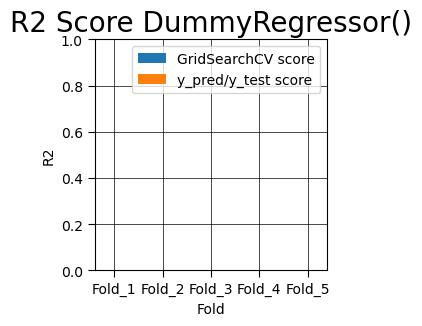

In [13]:
from sklearn.dummy import DummyRegressor
param_DataFrame_dic={}

Estimator = "DummyRegressor()"
param_grid = {'strategy' : ['mean', 'median','qauntile', 'constant']}
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))

regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)


### 2.2 Linear Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000300,3.232680,0.000432
1,LinearRegression(),0.173266,2.938872,0.000366



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000935,3.620696,0.000349
1,LinearRegression(),0.207886,3.220943,0.000332



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000256,3.573314,0.000482
1,LinearRegression(),-2.692997,6.866020,0.000283



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000003,3.280979,0.000366
1,LinearRegression(),0.095604,3.120198,0.000299



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-7.607102e-07,3.459097,0.000349
1,LinearRegression(),8.066102e-02,3.316655,0.001517




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score
0,Fold_1,NaN,NaN
1,Fold_2,NaN,NaN
2,Fold_3,NaN,NaN
3,Fold_4,NaN,NaN
4,Fold_5,NaN,NaN


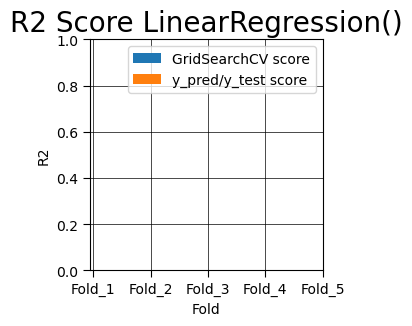

In [14]:
from sklearn.linear_model import LinearRegression

Estimator = "LinearRegression()"
param_grid = {}
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))


regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.3 Elastic Net
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000300,3.232680,0.000432
1,LinearRegression(),0.173266,2.938872,0.000366
2,ElasticNet(),0.128253,3.017816,0.001839



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000935,3.620696,0.000349
1,LinearRegression(),0.207886,3.220943,0.000332
2,ElasticNet(),0.129855,3.375865,0.001363



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000256,3.573314,0.000482
1,LinearRegression(),-2.692997,6.866020,0.000283
2,ElasticNet(),-0.040181,3.643931,0.001396



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000003,3.280979,0.000366
1,LinearRegression(),0.095604,3.120198,0.000299
2,ElasticNet(),0.087964,3.133349,0.001429



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-7.607102e-07,3.459097,0.000349
1,LinearRegression(),8.066102e-02,3.316655,0.001517
2,ElasticNet(),7.895251e-02,3.319736,0.001456




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,l1_ratio
0,Fold_1,0.085753,0.128253,0.1
1,Fold_2,0.071850,0.129855,0.1
2,Fold_3,0.090095,-0.040181,0.1
3,Fold_4,0.102448,0.087964,0.1
4,Fold_5,0.098817,0.078953,0.1


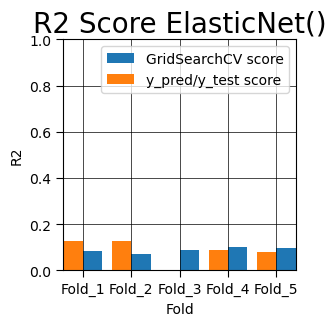

In [15]:
from sklearn.linear_model import ElasticNet

Estimator = "ElasticNet()"
param_grid = {'l1_ratio' : np.linspace(0.1,1,11).round(2)} 
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))


regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.4 SVR
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000300,3.232680,0.000432
1,LinearRegression(),0.173266,2.938872,0.000366
2,ElasticNet(),0.128253,3.017816,0.001839
3,SVR(),0.184527,2.918787,0.045088



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000935,3.620696,0.000349
1,LinearRegression(),0.207886,3.220943,0.000332
2,ElasticNet(),0.129855,3.375865,0.001363
3,SVR(),0.189626,3.257855,0.043487



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000256,3.573314,0.000482
1,LinearRegression(),-2.692997,6.866020,0.000283
2,ElasticNet(),-0.040181,3.643931,0.001396
3,SVR(),0.165784,3.263285,0.043734



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000003,3.280979,0.000366
1,LinearRegression(),0.095604,3.120198,0.000299
2,ElasticNet(),0.087964,3.133349,0.001429
3,SVR(),0.127647,3.064424,0.042986



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-7.607102e-07,3.459097,0.000349
1,LinearRegression(),8.066102e-02,3.316655,0.001517
2,ElasticNet(),7.895251e-02,3.319736,0.001456
3,SVR(),1.210337e-01,3.243012,0.043067




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,kernel,gamma
0,Fold_1,0.123266,0.184527,rbf,auto
1,Fold_2,0.115973,0.189626,rbf,scale
2,Fold_3,0.126853,0.165784,rbf,auto
3,Fold_4,0.139402,0.127647,rbf,scale
4,Fold_5,0.135947,0.121034,rbf,auto


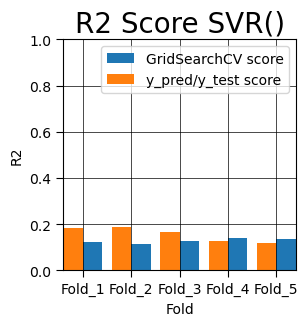

In [16]:
from sklearn.svm import SVR

Estimator = "SVR()"
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale','auto']
             }
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.5 RandomForestRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000300,3.232680,0.000432
1,LinearRegression(),0.173266,2.938872,0.000366
2,ElasticNet(),0.128253,3.017816,0.001839
3,SVR(),0.184527,2.918787,0.045088
4,RandomForestRegressor(),0.333687,2.638377,1.626445



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000935,3.620696,0.000349
1,LinearRegression(),0.207886,3.220943,0.000332
2,ElasticNet(),0.129855,3.375865,0.001363
3,SVR(),0.189626,3.257855,0.043487
4,RandomForestRegressor(),0.373740,2.863957,1.619280



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000256,3.573314,0.000482
1,LinearRegression(),-2.692997,6.866020,0.000283
2,ElasticNet(),-0.040181,3.643931,0.001396
3,SVR(),0.165784,3.263285,0.043734
4,RandomForestRegressor(),0.360351,2.857502,1.612453



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000003,3.280979,0.000366
1,LinearRegression(),0.095604,3.120198,0.000299
2,ElasticNet(),0.087964,3.133349,0.001429
3,SVR(),0.127647,3.064424,0.042986
4,RandomForestRegressor(),0.349391,2.646444,1.606519



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-7.607102e-07,3.459097,0.000349
1,LinearRegression(),8.066102e-02,3.316655,0.001517
2,ElasticNet(),7.895251e-02,3.319736,0.001456
3,SVR(),1.210337e-01,3.243012,0.043067
4,RandomForestRegressor(),3.147489e-01,2.863435,1.607037




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,criterion,n_estimators,n_jobs,min_samples_split,max_depth
0,Fold_1,0.315643,0.333687,poisson,2000,-1,2,9
1,Fold_2,0.301582,0.373740,poisson,2000,-1,2,9
2,Fold_3,0.309573,0.360351,poisson,2000,-1,5,9
3,Fold_4,0.313161,0.349391,poisson,2000,-1,8,9
4,Fold_5,0.324958,0.314749,poisson,2000,-1,8,9


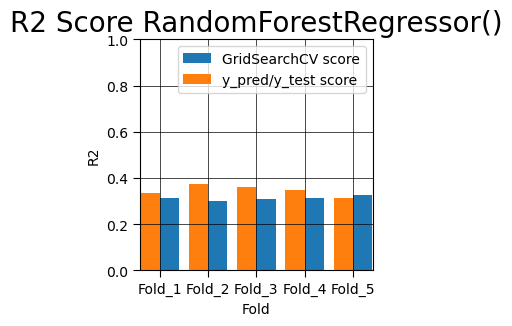

In [17]:
from sklearn.ensemble import RandomForestRegressor

Estimator = "RandomForestRegressor()"
param_grid = {'criterion' : ["poisson"],
              'n_estimators' : [2000],
              'n_jobs':[-1],
              'min_samples_split': [2,5,8] ,
              'max_depth':[3,6,9]
             }
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.6 GradientBoostingRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000300,3.232680,0.000432
1,LinearRegression(),0.173266,2.938872,0.000366
2,ElasticNet(),0.128253,3.017816,0.001839
3,SVR(),0.184527,2.918787,0.045088
4,RandomForestRegressor(),0.333687,2.638377,1.626445
5,GradientBoostingRegressor(),0.373450,2.558443,3.665780



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000935,3.620696,0.000349
1,LinearRegression(),0.207886,3.220943,0.000332
2,ElasticNet(),0.129855,3.375865,0.001363
3,SVR(),0.189626,3.257855,0.043487
4,RandomForestRegressor(),0.373740,2.863957,1.619280
5,GradientBoostingRegressor(),0.377476,2.855403,3.690435



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000256,3.573314,0.000482
1,LinearRegression(),-2.692997,6.866020,0.000283
2,ElasticNet(),-0.040181,3.643931,0.001396
3,SVR(),0.165784,3.263285,0.043734
4,RandomForestRegressor(),0.360351,2.857502,1.612453
5,GradientBoostingRegressor(),0.391481,2.787100,3.676898



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000003,3.280979,0.000366
1,LinearRegression(),0.095604,3.120198,0.000299
2,ElasticNet(),0.087964,3.133349,0.001429
3,SVR(),0.127647,3.064424,0.042986
4,RandomForestRegressor(),0.349391,2.646444,1.606519
5,GradientBoostingRegressor(),0.358335,2.628191,3.661713



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-7.607102e-07,3.459097,0.000349
1,LinearRegression(),8.066102e-02,3.316655,0.001517
2,ElasticNet(),7.895251e-02,3.319736,0.001456
3,SVR(),1.210337e-01,3.243012,0.043067
4,RandomForestRegressor(),3.147489e-01,2.863435,1.607037
5,GradientBoostingRegressor(),3.286906e-01,2.834157,3.676960




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,loss,subsample,criterion,learning_rate,n_estimators,max_depth
0,Fold_1,0.309433,0.373450,huber,0.5,friedman_mse,0.01,500,5
1,Fold_2,0.302866,0.377476,huber,0.5,friedman_mse,0.01,500,5
2,Fold_3,0.312706,0.391481,huber,0.5,friedman_mse,0.01,500,5
3,Fold_4,0.319686,0.358335,huber,0.5,friedman_mse,0.01,500,5
4,Fold_5,0.325314,0.328691,huber,0.5,friedman_mse,0.01,500,5


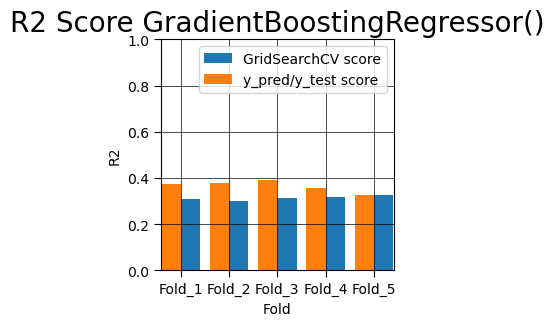

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

Estimator = "GradientBoostingRegressor()"
param_grid = {'loss' : ['squared_error', 'huber'],
              'subsample' : np.linspace(0.01,1,3).round(2),
              'criterion' : ['friedman_mse'],
              'learning_rate':np.linspace(0.01,1,3).round(2),
              'n_estimators':[500],
              'max_depth':[3,5]
             }
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.7 XGBoost

https://xgboost.readthedocs.io/en/stable/parameter.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000300,3.232680,0.000432
1,LinearRegression(),0.173266,2.938872,0.000366
2,ElasticNet(),0.128253,3.017816,0.001839
3,SVR(),0.184527,2.918787,0.045088
4,RandomForestRegressor(),0.333687,2.638377,1.626445
5,GradientBoostingRegressor(),0.373450,2.558443,3.665780
6,xgb.XGBRegressor(),0.287628,2.728043,0.544393



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000935,3.620696,0.000349
1,LinearRegression(),0.207886,3.220943,0.000332
2,ElasticNet(),0.129855,3.375865,0.001363
3,SVR(),0.189626,3.257855,0.043487
4,RandomForestRegressor(),0.373740,2.863957,1.619280
5,GradientBoostingRegressor(),0.377476,2.855403,3.690435
6,xgb.XGBRegressor(),0.377690,2.854911,0.598412



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000256,3.573314,0.000482
1,LinearRegression(),-2.692997,6.866020,0.000283
2,ElasticNet(),-0.040181,3.643931,0.001396
3,SVR(),0.165784,3.263285,0.043734
4,RandomForestRegressor(),0.360351,2.857502,1.612453
5,GradientBoostingRegressor(),0.391481,2.787100,3.676898
6,xgb.XGBRegressor(),0.362300,2.853145,0.648295



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000003,3.280979,0.000366
1,LinearRegression(),0.095604,3.120198,0.000299
2,ElasticNet(),0.087964,3.133349,0.001429
3,SVR(),0.127647,3.064424,0.042986
4,RandomForestRegressor(),0.349391,2.646444,1.606519
5,GradientBoostingRegressor(),0.358335,2.628191,3.661713
6,xgb.XGBRegressor(),0.337107,2.671311,0.637566



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-7.607102e-07,3.459097,0.000349
1,LinearRegression(),8.066102e-02,3.316655,0.001517
2,ElasticNet(),7.895251e-02,3.319736,0.001456
3,SVR(),1.210337e-01,3.243012,0.043067
4,RandomForestRegressor(),3.147489e-01,2.863435,1.607037
5,GradientBoostingRegressor(),3.286906e-01,2.834157,3.676960
6,xgb.XGBRegressor(),3.335936e-01,2.823788,0.649717




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,booster,eta,objective
0,Fold_1,0.284311,0.287628,gbtree,0.1,reg:squarederror
1,Fold_2,0.246920,0.377690,gbtree,0.1,reg:squarederror
2,Fold_3,0.290797,0.362300,dart,0.1,reg:squarederror
3,Fold_4,0.289534,0.337107,dart,0.1,reg:squarederror
4,Fold_5,0.270337,0.333594,dart,0.1,reg:squarederror


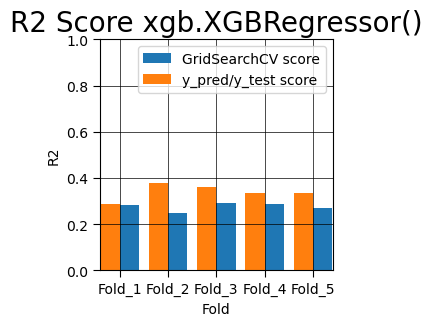

In [19]:
import xgboost as xgb


Estimator = "xgb.XGBRegressor()"
param_grid = {'booster' : ['gblinear', 'gbtree', 'dart'],
              'eta' : np.linspace(0,1,11).round(2),
              'objective': ['reg:squarederror']}
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.8 LGBMRegressor
https://lightgbm.readthedocs.io/en/latest/Parameters.html


Fold_1 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000300,3.232680,0.000432
1,LinearRegression(),0.173266,2.938872,0.000366
2,ElasticNet(),0.128253,3.017816,0.001839
3,SVR(),0.184527,2.918787,0.045088
4,RandomForestRegressor(),0.333687,2.638377,1.626445
5,GradientBoostingRegressor(),0.373450,2.558443,3.665780
6,xgb.XGBRegressor(),0.287628,2.728043,0.544393
7,lgb.LGBMRegressor(),0.294736,2.714398,0.401111



Fold_2 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000935,3.620696,0.000349
1,LinearRegression(),0.207886,3.220943,0.000332
2,ElasticNet(),0.129855,3.375865,0.001363
3,SVR(),0.189626,3.257855,0.043487
4,RandomForestRegressor(),0.373740,2.863957,1.619280
5,GradientBoostingRegressor(),0.377476,2.855403,3.690435
6,xgb.XGBRegressor(),0.377690,2.854911,0.598412
7,lgb.LGBMRegressor(),0.323149,2.977391,0.411667



Fold_3 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000256,3.573314,0.000482
1,LinearRegression(),-2.692997,6.866020,0.000283
2,ElasticNet(),-0.040181,3.643931,0.001396
3,SVR(),0.165784,3.263285,0.043734
4,RandomForestRegressor(),0.360351,2.857502,1.612453
5,GradientBoostingRegressor(),0.391481,2.787100,3.676898
6,xgb.XGBRegressor(),0.362300,2.853145,0.648295
7,lgb.LGBMRegressor(),0.354246,2.871106,0.397505



Fold_4 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-0.000003,3.280979,0.000366
1,LinearRegression(),0.095604,3.120198,0.000299
2,ElasticNet(),0.087964,3.133349,0.001429
3,SVR(),0.127647,3.064424,0.042986
4,RandomForestRegressor(),0.349391,2.646444,1.606519
5,GradientBoostingRegressor(),0.358335,2.628191,3.661713
6,xgb.XGBRegressor(),0.337107,2.671311,0.637566
7,lgb.LGBMRegressor(),0.288417,2.767679,0.409992



Fold_5 :


,Estimator,R2,RMSE,Time_min
0,DummyRegressor(),-7.607102e-07,3.459097,0.000349
1,LinearRegression(),8.066102e-02,3.316655,0.001517
2,ElasticNet(),7.895251e-02,3.319736,0.001456
3,SVR(),1.210337e-01,3.243012,0.043067
4,RandomForestRegressor(),3.147489e-01,2.863435,1.607037
5,GradientBoostingRegressor(),3.286906e-01,2.834157,3.676960
6,xgb.XGBRegressor(),3.335936e-01,2.823788,0.649717
7,lgb.LGBMRegressor(),3.160561e-01,2.860703,0.398624




PARAM_GRID_RESULTS:


,Fold#,grid_best_score,score,boosting_type,learning_rate,objective
0,Fold_1,0.311316,0.294736,goss,0.11,regression
1,Fold_2,0.272983,0.323149,gbdt,0.11,regression_l1
2,Fold_3,0.310366,0.354246,gbdt,0.11,regression_l1
3,Fold_4,0.313446,0.288417,goss,0.11,regression
4,Fold_5,0.291529,0.316056,gbdt,0.11,regression_l1


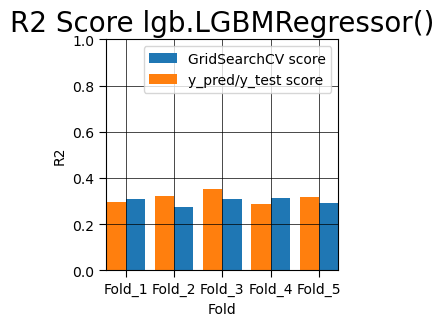

In [20]:
import lightgbm as lgb


Estimator = "lgb.LGBMRegressor()"
param_grid = {'boosting_type' : ['gbdt', 'dart', 'goss'],
              'learning_rate' : np.linspace(0.01,1,11).round(2),
              'objective': ['regression', 'regression_l1']}
param_DataFrame_dic[Estimator] = pd.DataFrame(columns=['grid_best_score', 'score']+list(param_grid.keys()))



regressor(split_dict, Estimator, param_grid, param_DataFrame_dic)

### 2.9 regression_results_data.sort_values('R2_mean')

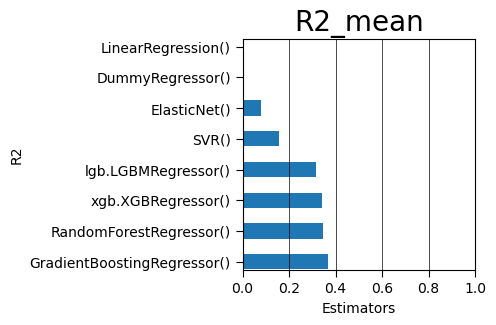

,Estimator,Fold_1_R2,Fold_2_R2,Fold_3_R2,Fold_4_R2,Fold_5_R2,R2_mean,Time_mean,RMSE_mean
5,GradientBoostingRegressor(),0.373450,0.377476,0.391481,0.358335,3.286906e-01,0.365886,3.674357,2.732659
4,RandomForestRegressor(),0.333687,0.373740,0.360351,0.349391,3.147489e-01,0.346384,1.614347,2.773943
6,xgb.XGBRegressor(),0.287628,0.377690,0.362300,0.337107,3.335936e-01,0.339664,0.615677,2.786240
7,lgb.LGBMRegressor(),0.294736,0.323149,0.354246,0.288417,3.160561e-01,0.315321,0.403780,2.838255
3,SVR(),0.184527,0.189626,0.165784,0.127647,1.210337e-01,0.157724,0.043672,3.149473
2,ElasticNet(),0.128253,0.129855,-0.040181,0.087964,7.895251e-02,0.076969,0.001497,3.298140
0,DummyRegressor(),-0.000300,-0.000935,-0.000256,-0.000003,-7.607102e-07,-0.000299,0.000396,3.433353
1,LinearRegression(),0.173266,0.207886,-2.692997,0.095604,8.066102e-02,-0.427116,0.000559,3.892538


In [32]:
regression_results_data = pd.DataFrame()
regression_results_data['Estimator'] = split_dict['Fold_1'][4]['Estimator']
for key, values in split_dict.items():
    regression_results_data[key+'_R2'] = values[4].loc[:,'R2']
    regression_results_data[key+'_time'] = values[4].loc[:,'Time_min']
    regression_results_data[key+'_rmse'] = values[4].loc[:,'RMSE']

regression_results_data['R2_mean'] = (regression_results_data.loc[:,['R2' in x for x in regression_results_data.columns]]).mean(axis=1)
regression_results_data['Time_mean'] = (regression_results_data.loc[:,['time' in x for x in regression_results_data.columns]]).mean(axis=1)
regression_results_data['RMSE_mean'] = (regression_results_data.loc[:,['rmse' in x for x in regression_results_data.columns]]).mean(axis=1)

regression_results_data = regression_results_data.drop(columns = regression_results_data.loc[:,['time' in x for x in regression_results_data.columns]].columns)
regression_results_data = regression_results_data.drop(columns = regression_results_data.loc[:,['rmse' in x for x in regression_results_data.columns]].columns)



r2_mean_barplot(regression_results_data.sort_values('R2_mean', ascending=False))
regression_results_data.sort_values('R2_mean', ascending=False)



## 3. EnergyStarScore

### 3.1 Best estimator and best param grid

In [33]:
features.append('ENERGYSTARScore')

Estimator = (regression_results_data.sort_values('R2_mean', ascending=False, ignore_index=True)).loc[0,'Estimator']
param = pd.DataFrame(param_DataFrame_dic[Estimator].mode().iloc[0,3:])
param_grid = {param.index[i]:[param.iloc[i,0]] for i in range(len(param))}

### 3.2 EnergyStarScore not NaN



Fold_1
R2 score : 0.4480711485572154



Permutation explainer: 199it [00:58,  2.91it/s]                         


,Feature,Feature_Importance
0,ENERGYSTARScore,1.110837
1,Electricity(kBtu)_%,0.600672
2,SiteEnergyUse(kBtu)_%,0.593956
3,STORE_WAREHOUSE,0.213579
4,Longitude,0.209114
5,District_#1_#2,0.198309
6,OFFICE,0.182696
7,LOUNGES,0.158446
8,OSEBuildingID,0.153500
9,OTHER,0.123993


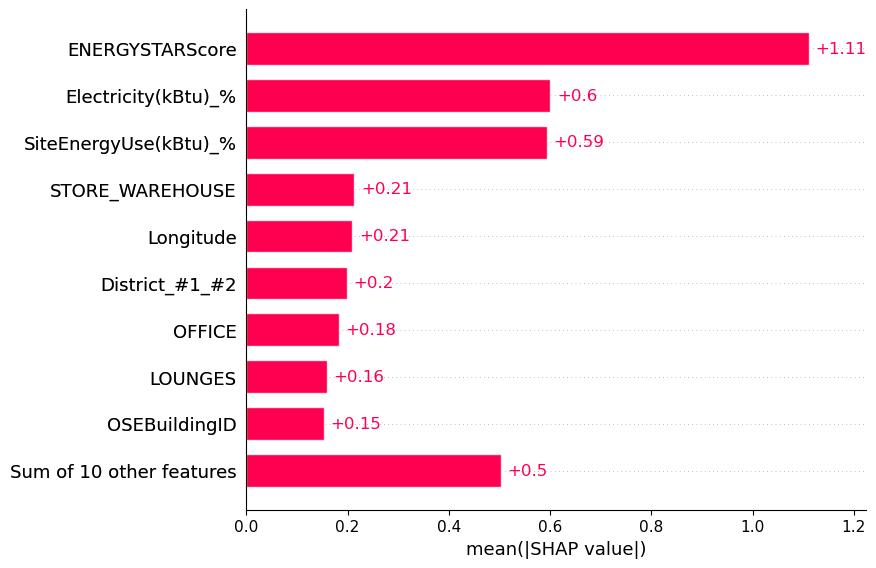



Fold_2
R2 score : 0.534199106387087



Permutation explainer: 199it [00:55,  2.92it/s]                         


,Feature,Feature_Importance
0,ENERGYSTARScore,0.935862
1,SiteEnergyUse(kBtu)_%,0.560969
2,Electricity(kBtu)_%,0.513171
3,OFFICE,0.214979
4,Longitude,0.207546
5,STORE_WAREHOUSE,0.195553
6,OSEBuildingID,0.189468
7,OTHER,0.142476
8,District_#1_#2,0.139796
9,LOUNGES,0.096420


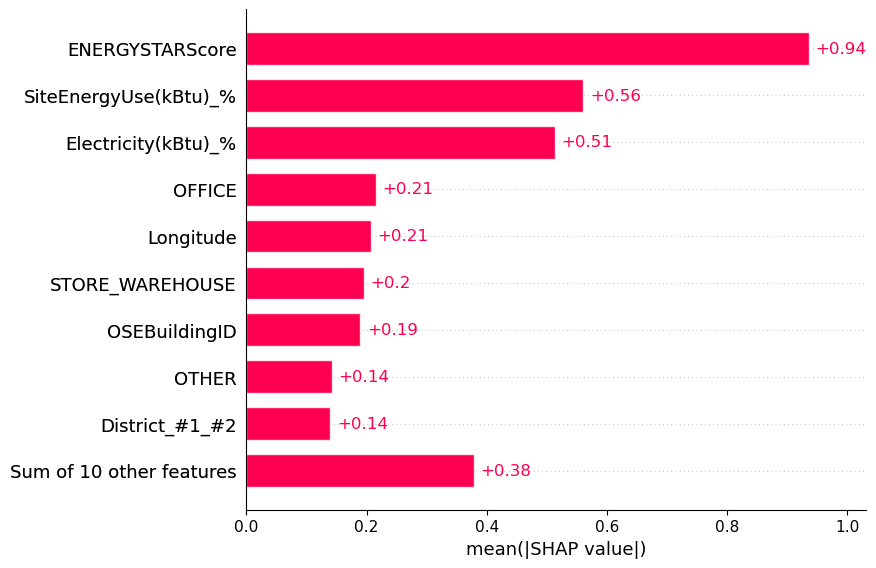



Fold_3
R2 score : 0.4797720945368267



Permutation explainer: 198it [00:58,  2.81it/s]                         


,Feature,Feature_Importance
0,ENERGYSTARScore,1.010739
1,SiteEnergyUse(kBtu)_%,0.599891
2,Electricity(kBtu)_%,0.594224
3,OFFICE,0.233164
4,OTHER,0.206408
5,Longitude,0.179537
6,OSEBuildingID,0.174277
7,District_#1_#2,0.150421
8,LOUNGES,0.146035
9,NumberofFloors,0.138471


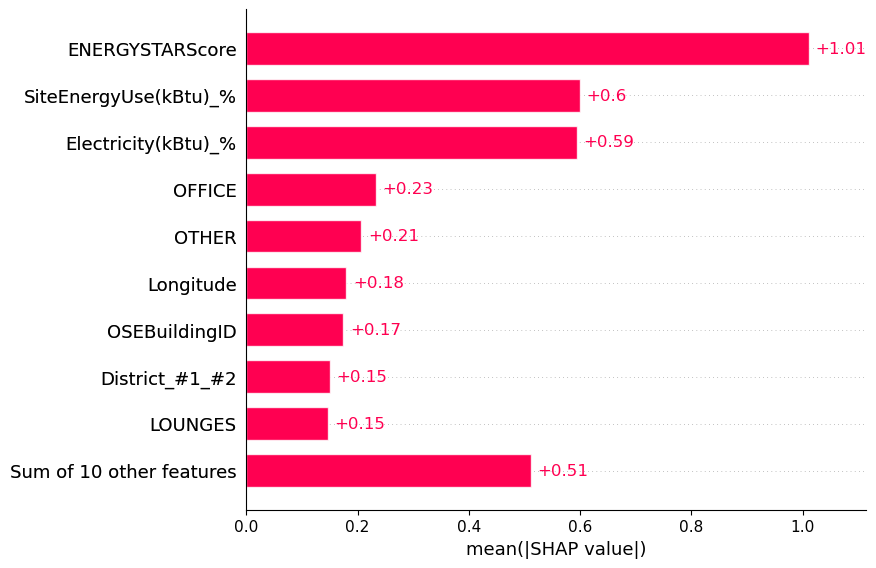



Fold_4
R2 score : 0.6136300864360285



Permutation explainer: 198it [00:58,  2.84it/s]                         


,Feature,Feature_Importance
0,ENERGYSTARScore,1.026683
1,SiteEnergyUse(kBtu)_%,0.733440
2,Electricity(kBtu)_%,0.476350
3,OFFICE,0.241458
4,Longitude,0.182743
5,LOUNGES,0.169373
6,District_#1_#2,0.150715
7,OSEBuildingID,0.113925
8,STORE_WAREHOUSE,0.106494
9,PropertyGFATotal,0.103367


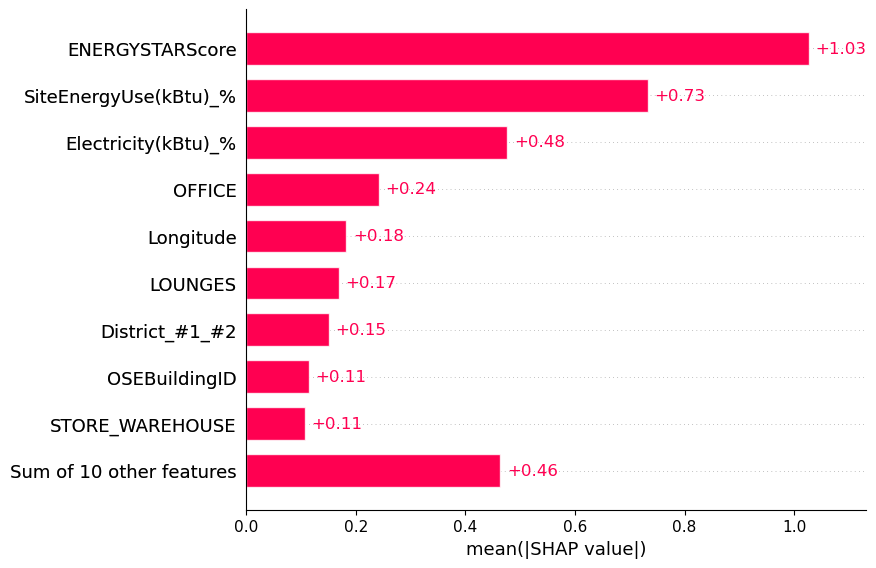



Fold_5
R2 score : 0.45176631914273635



Permutation explainer: 198it [00:54,  2.97it/s]                         


,Feature,Feature_Importance
0,ENERGYSTARScore,0.926972
1,Electricity(kBtu)_%,0.579963
2,SiteEnergyUse(kBtu)_%,0.531408
3,District_#1_#2,0.228588
4,OFFICE,0.180919
5,Longitude,0.156138
6,YearBuilt,0.125447
7,OSEBuildingID,0.124886
8,STORE_WAREHOUSE,0.119556
9,OTHER,0.104576


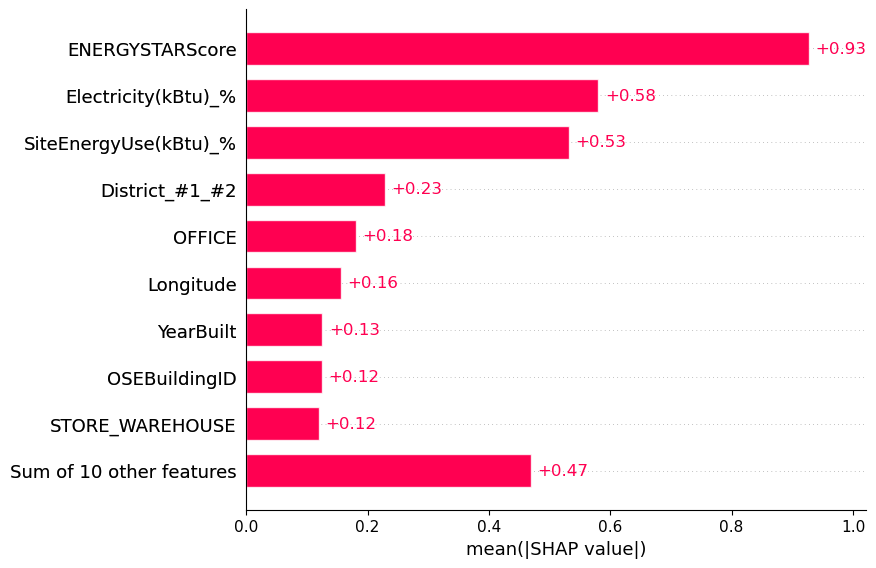

,Estimator,Fold_1_R2,Fold_2_R2,Fold_3_R2,Fold_4_R2,Fold_5_R2,R2_mean,Time_mean,RMSE_mean
8,GradientBoostingRegressor()_notna_EnergyStarScore,0.448071,0.534199,0.479772,0.613630,4.517663e-01,0.505488,0.312593,2.206580
5,GradientBoostingRegressor(),0.373450,0.377476,0.391481,0.358335,3.286906e-01,0.365886,3.674357,2.732659
4,RandomForestRegressor(),0.333687,0.373740,0.360351,0.349391,3.147489e-01,0.346384,1.614347,2.773943
6,xgb.XGBRegressor(),0.287628,0.377690,0.362300,0.337107,3.335936e-01,0.339664,0.615677,2.786240
7,lgb.LGBMRegressor(),0.294736,0.323149,0.354246,0.288417,3.160561e-01,0.315321,0.403780,2.838255
3,SVR(),0.184527,0.189626,0.165784,0.127647,1.210337e-01,0.157724,0.043672,3.149473
2,ElasticNet(),0.128253,0.129855,-0.040181,0.087964,7.895251e-02,0.076969,0.001497,3.298140
0,DummyRegressor(),-0.000300,-0.000935,-0.000256,-0.000003,-7.607102e-07,-0.000299,0.000396,3.433353
1,LinearRegression(),0.173266,0.207886,-2.692997,0.095604,8.066102e-02,-0.427116,0.000559,3.892538


,Fold,shap_rank,shap_value
0,Fold_1,1,1.110837
1,Fold_2,1,0.935862
2,Fold_3,1,1.010739
3,Fold_4,1,1.026683
4,Fold_5,1,0.926972


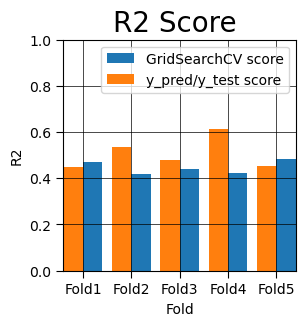

In [34]:
data_notna = df.loc[df['ENERGYSTARScore'].notna()]
data_notna.reset_index(inplace=True) 

regression_results_data, EnergyStarScore_notna_shap_df, EnergyStarScore_notna_dict, R2_score_GridSearchCV_notna = regression_with_EnergyStarScore(data_notna, features, y_feature, Estimator, param_grid,'_notna_EnergyStarScore',regression_results_data)

display(regression_results_data.sort_values('R2_mean', ascending=False))
display(EnergyStarScore_notna_shap_df)

plot_r2_score(R2_score_GridSearchCV_notna)

### 3.3 EnergyStarScore median



Fold_1
R2 score : 0.5293283737584027



Permutation explainer: 306it [01:21,  3.29it/s]                         


,Feature,Feature_Importance
0,SiteEnergyUse(kBtu)_%,0.834912
1,ENERGYSTARScore,0.634627
2,Electricity(kBtu)_%,0.582753
3,OTHER,0.278595
4,STORE_WAREHOUSE,0.222978
5,PropertyGFATotal,0.174173
6,Longitude,0.173041
7,YearBuilt,0.148686
8,OSEBuildingID,0.121237
9,OFFICE,0.118376


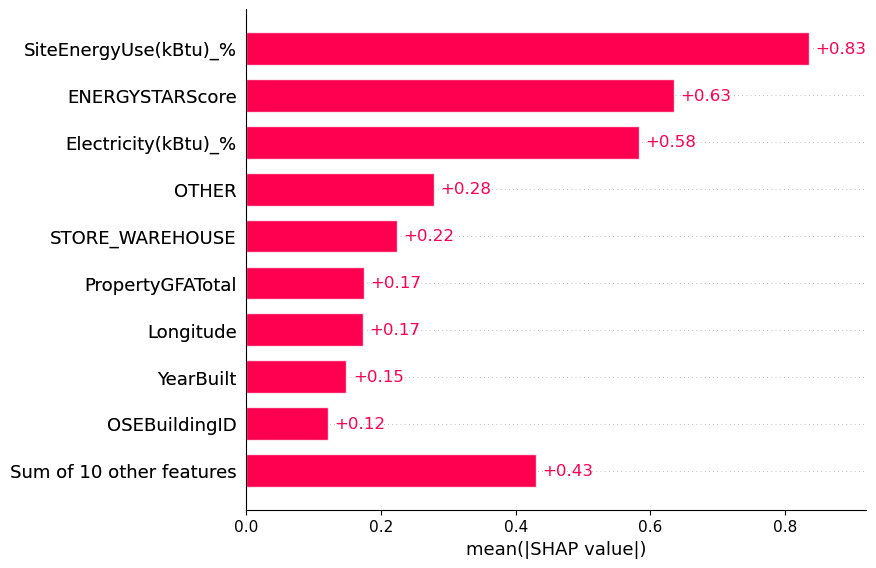



Fold_2
R2 score : 0.4266576939281159



Permutation explainer: 306it [01:20,  3.33it/s]                         


,Feature,Feature_Importance
0,SiteEnergyUse(kBtu)_%,0.907228
1,ENERGYSTARScore,0.626482
2,Electricity(kBtu)_%,0.527975
3,OTHER,0.381373
4,STORE_WAREHOUSE,0.187430
5,Longitude,0.179097
6,YearBuilt,0.161935
7,PropertyGFATotal,0.141471
8,District_#1_#2,0.134866
9,OSEBuildingID,0.085766


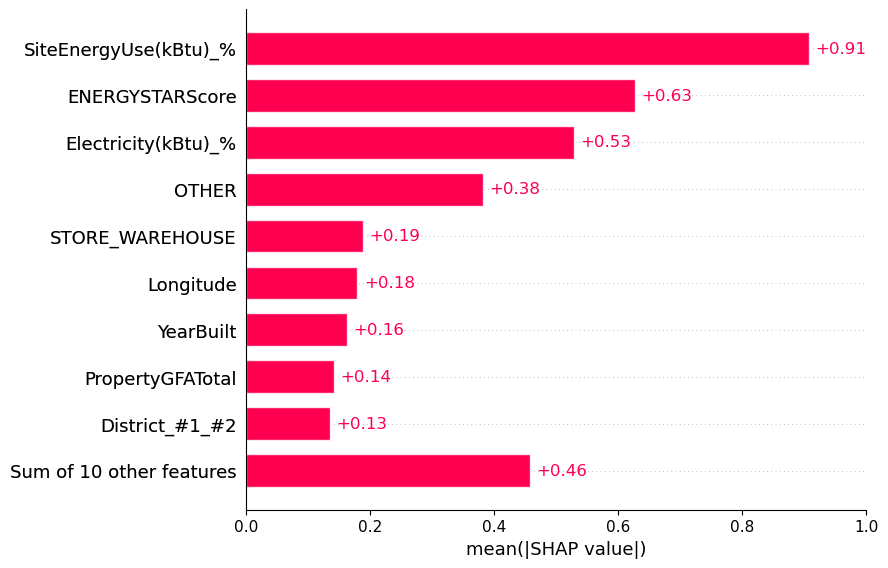



Fold_3
R2 score : 0.4615436232074669



Permutation explainer: 306it [01:23,  3.23it/s]                         


,Feature,Feature_Importance
0,SiteEnergyUse(kBtu)_%,0.875726
1,ENERGYSTARScore,0.652988
2,Electricity(kBtu)_%,0.497693
3,STORE_WAREHOUSE,0.290317
4,OTHER,0.255810
5,PropertyGFATotal,0.171000
6,Longitude,0.154682
7,OSEBuildingID,0.136507
8,YearBuilt,0.131521
9,OFFICE,0.109207


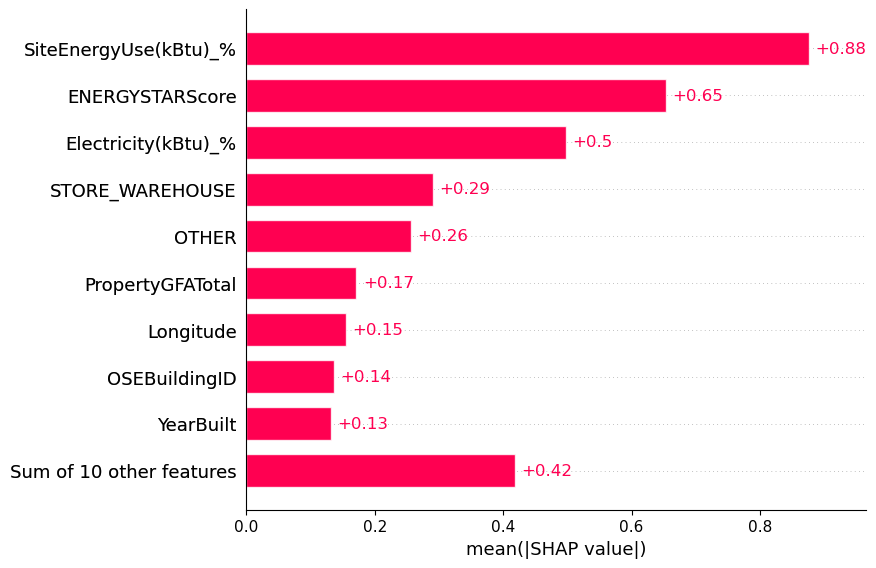



Fold_4
R2 score : 0.4223660710764089



Permutation explainer: 306it [01:24,  3.21it/s]                         


,Feature,Feature_Importance
0,SiteEnergyUse(kBtu)_%,0.902334
1,ENERGYSTARScore,0.550023
2,Electricity(kBtu)_%,0.501243
3,OTHER,0.349297
4,STORE_WAREHOUSE,0.231710
5,YearBuilt,0.193583
6,PropertyGFATotal,0.176569
7,Longitude,0.162992
8,District_#1_#2,0.118952
9,OSEBuildingID,0.104057


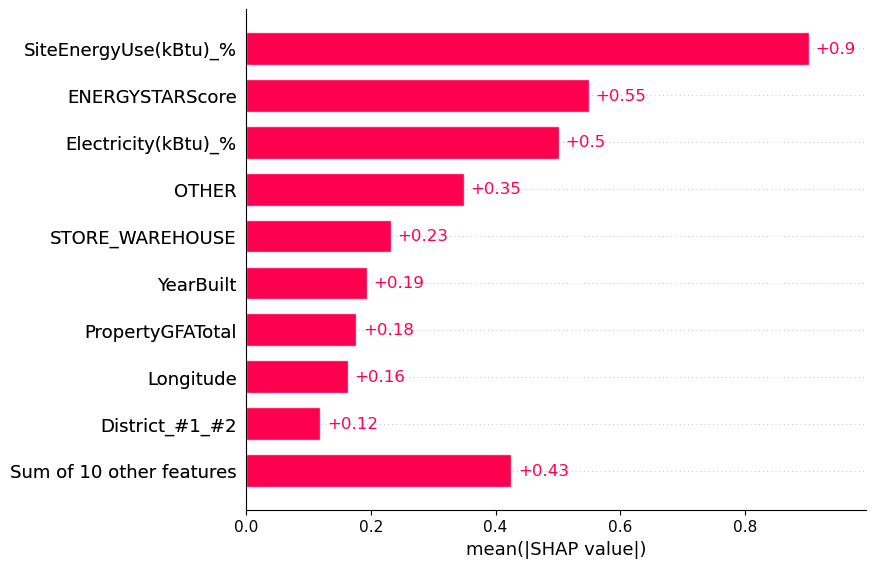



Fold_5
R2 score : 0.4071812481489626



Permutation explainer: 306it [01:25,  3.15it/s]                         


,Feature,Feature_Importance
0,SiteEnergyUse(kBtu)_%,1.029676
1,Electricity(kBtu)_%,0.611216
2,ENERGYSTARScore,0.555273
3,OTHER,0.548253
4,STORE_WAREHOUSE,0.234564
5,YearBuilt,0.214275
6,PropertyGFATotal,0.172676
7,Longitude,0.153576
8,OSEBuildingID,0.106883
9,OFFICE,0.096851


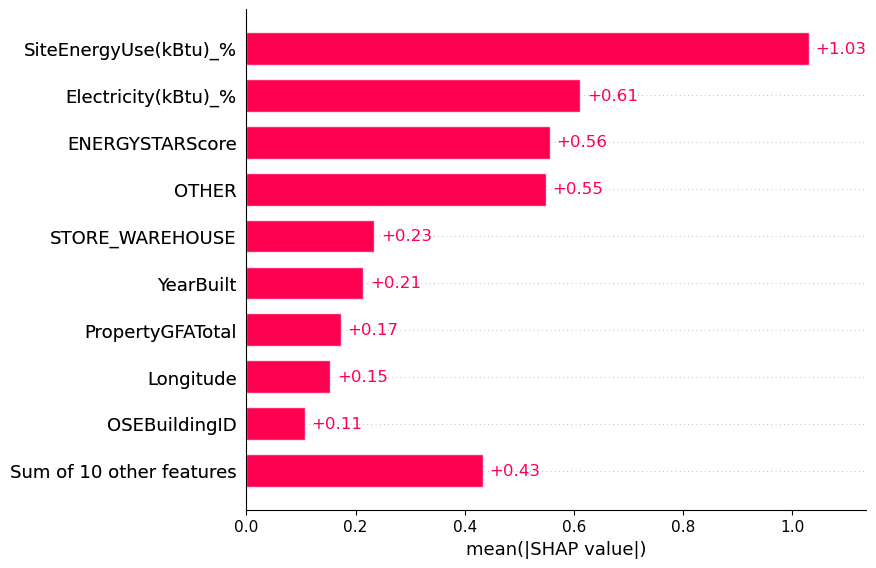

,Fold,shap_rank,shap_value
0,Fold_1,2,0.634627
1,Fold_2,2,0.626482
2,Fold_3,2,0.652988
3,Fold_4,2,0.550023
4,Fold_5,3,0.555273


NameError: name 'r2_mean_barplot' is not defined

In [35]:
data_median = pd.DataFrame(df)
data_median.loc[data_median['ENERGYSTARScore'].isna(),'ENERGYSTARScore'] = data_median.loc[data_median['ENERGYSTARScore'].notna(),'ENERGYSTARScore'].median()
data_median.reset_index(inplace=True)


regression_results_data, EnergyStarScore_median_shap_df, EnergyStarScore_median_dict, R2_score_GridSearchCV_median = regression_with_EnergyStarScore(data_median, features, y_feature, Estimator, param_grid,'_median_EnergyStarScore',regression_results_data)


display(EnergyStarScore_median_shap_df)

r2_mean_barplot(regression_results_data.sort_values('R2_mean', ascending=False))
display(regression_results_data.sort_values('R2_mean', ascending=False))

plot_r2_score(R2_score_GridSearchCV_median)

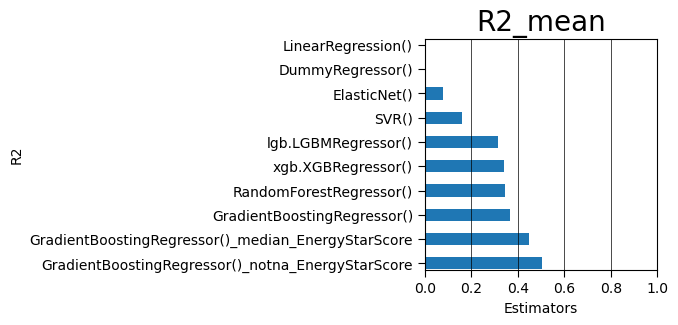

,Estimator,Fold_1_R2,Fold_2_R2,Fold_3_R2,Fold_4_R2,Fold_5_R2,R2_mean,Time_mean,RMSE_mean
8,GradientBoostingRegressor()_notna_EnergyStarScore,0.448071,0.534199,0.479772,0.613630,4.517663e-01,0.505488,0.312593,2.206580
9,GradientBoostingRegressor()_median_EnergyStarS...,0.529328,0.426658,0.461544,0.422366,4.071812e-01,0.449415,0.332058,2.541883
5,GradientBoostingRegressor(),0.373450,0.377476,0.391481,0.358335,3.286906e-01,0.365886,3.674357,2.732659
4,RandomForestRegressor(),0.333687,0.373740,0.360351,0.349391,3.147489e-01,0.346384,1.614347,2.773943
6,xgb.XGBRegressor(),0.287628,0.377690,0.362300,0.337107,3.335936e-01,0.339664,0.615677,2.786240
7,lgb.LGBMRegressor(),0.294736,0.323149,0.354246,0.288417,3.160561e-01,0.315321,0.403780,2.838255
3,SVR(),0.184527,0.189626,0.165784,0.127647,1.210337e-01,0.157724,0.043672,3.149473
2,ElasticNet(),0.128253,0.129855,-0.040181,0.087964,7.895251e-02,0.076969,0.001497,3.298140
0,DummyRegressor(),-0.000300,-0.000935,-0.000256,-0.000003,-7.607102e-07,-0.000299,0.000396,3.433353
1,LinearRegression(),0.173266,0.207886,-2.692997,0.095604,8.066102e-02,-0.427116,0.000559,3.892538


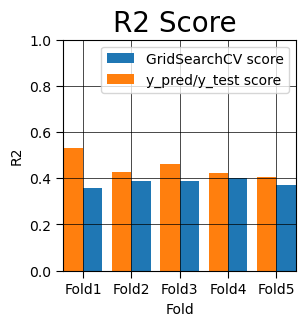

In [37]:
r2_mean_barplot(regression_results_data.sort_values('R2_mean', ascending=False))
display(regression_results_data.sort_values('R2_mean', ascending=False))

plot_r2_score(R2_score_GridSearchCV_median)

### 3.4 Overfitting

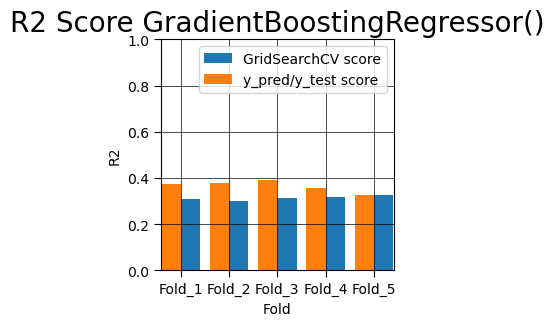

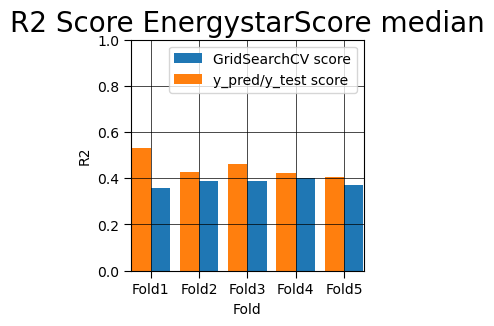

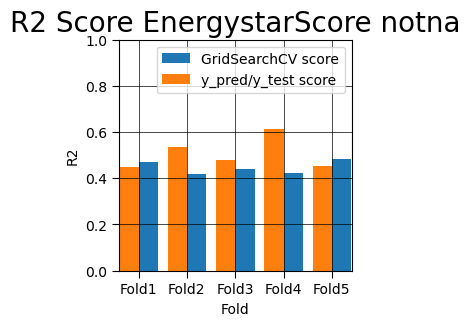

In [38]:
plot_r2_score(param_DataFrame_dic[Estimator],title=Estimator)

plot_r2_score(R2_score_GridSearchCV_median, title='EnergystarScore median' )

plot_r2_score(R2_score_GridSearchCV_notna, title='EnergystarScore notna')